# Trénovanie modelu iba na základe DST indexu 6 h dozadu, predikcia súčasnej hodnoty
Súbor: 6_dozadu.ipynb

Program: Hospodárska informatika

Vypracovala: Bc. Veronika Motúzová

Diplomová práca: : Predikcia geomagnetickych búrok pomocou hlbokého učenia

Vedúci diplomovej práce: doc. Ing. Peter Butka, PhD.

Konzultanti: Ing. Viera Maslej Krešňáková, PhD., RNDr. Šimon Mackovjak, PhD. 

### Inštalácia knižníc

In [1]:
!pip install pyarrow
!pip install keras
!pip install --upgrade tensorflow
!pip install --upgrade tensorflow-gpu

     |████████████████████████████████| 29.4 MB 7.7 MB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 7.4 MB/s eta 0:00:01
     |████████████████████████████████| 511.7 MB 43 kB/s s eta 0:00:01
     |████████████████████████████████| 123 kB 58.0 MB/s eta 0:00:01
     |████████████████████████████████| 14.5 MB 61.0 MB/s eta 0:00:01
     |████████████████████████████████| 17.1 MB 72.7 MB/s eta 0:00:01
     |████████████████████████████████| 5.8 MB 67.8 MB/s eta 0:00:01
     |████████████████████████████████| 4.9 MB 77.2 MB/s eta 0:00:01
     |████████████████████████████████| 438 kB 77.0 MB/s eta 0:00:01
     |████████████████████████████████| 2.4 MB 44.9 MB/s eta 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.18.5
    Uninstalling numpy-1.18.5:
      Successfully uninstalled numpy-1.18.5
  Attempting uninstall: absl-py
    Found existing installation: absl-py 0.11.0
    Uninstalling absl-py-0.11.0:
      Successfully uninstalled absl-py-0.11

### Kontrola kapacity servera

In [2]:
!nvidia-smi

Mon Mar 13 14:29:47 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K40c          Off  | 00000000:01:00.0 Off |                    0 |
| 24%   47C    P0    71W / 235W |      0MiB / 11441MiB |     66%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Import knižníc

In [1]:
import pandas as pd
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns

from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential

from keras.layers import Dense, Activation, Dropout, Input, Conv1D, LSTM, MaxPooling1D, Flatten, TimeDistributed, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Model


from scipy.special import expit, logit

from sklearn.metrics import confusion_matrix, classification_report, matthews_corrcoef

### Načitanie dát, odstránenie na hodnôt, určenie predikovaného atribútu

In [3]:
train = pd.read_csv('train_omni.csv')
test = pd.read_csv('test_omni.csv')
features = ['time1',
            'DST']
test = test[features]
train = train[features]
train['time1']=pd.to_datetime(train['time1'])
test['time1']=pd.to_datetime(test['time1'])
predicted_label = 'DST'

y_col='DST'
valid_size = int(len(train) * 0.2)
valid = train.iloc[-valid_size:,:].copy()
train = train.iloc[:-valid_size,:].copy()

y_train = train[y_col].values.copy()
X_train = train[y_col].values.copy()
y_val = valid[y_col].values.copy()
X_val = valid[y_col].values.copy()
y_test = test[y_col].values.copy()
X_test = test[y_col].values.copy()

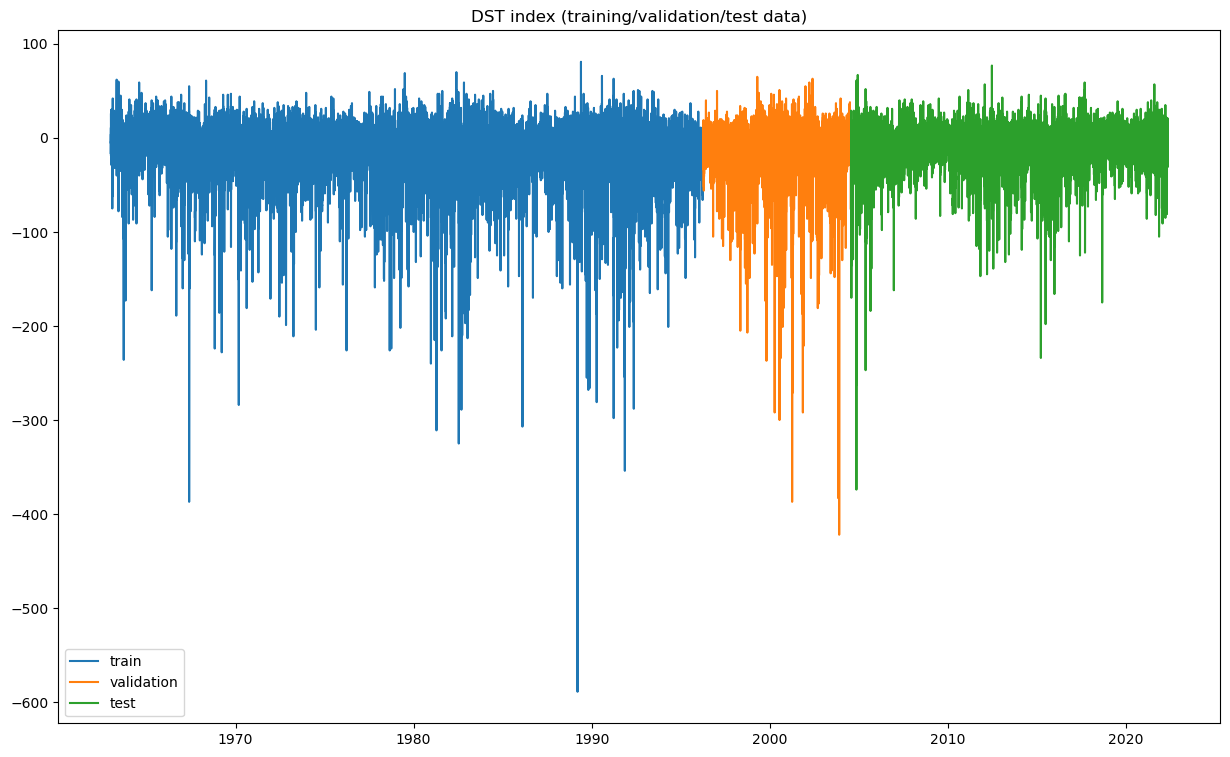

In [4]:
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
%matplotlib inline
register_matplotlib_converters()

plt.rcParams['figure.figsize'] = [15, 9]
plt.figure()
plt.title("DST index (training/validation/test data)")
plt.plot(train['time1'],train['DST'],label='train')
plt.plot(valid['time1'],valid['DST'],label='validation')
plt.plot(test['time1'],test['DST'],label='test')
plt.legend();

In [5]:
# set batch, n_input, n_features

n_input = 6  # how many samples/rows/timesteps to look in the past in order to forecast the next sample
n_features= len(X_train)  # how many predictors/Xs/features we have to predict y
b_size = 256  # Number of timeseries samples in each batch

train_generator = TimeseriesGenerator(X_train, y_train, length=n_input, batch_size=b_size)
val_generator = TimeseriesGenerator(X_val, y_val, length=n_input, batch_size=b_size)
test_generator = TimeseriesGenerator(X_test, y_test, length=n_input, batch_size=256)

In [6]:
print("Počet batchov: ", len(train_generator))
print("Každý batch má features (X zložku) a labels (y zložku): ", len(train_generator[0]))
print("Dĺžka X zložky batchu: ", len(train_generator[0][0]))
print("Dĺžka y zložky batchu (počet meraní v batchi): ",len(train_generator[0][1]))
print("Počet riadkov braných do úvahy pre jedno meranie (koľko sa pozerá dozadu): ", len(train_generator[0][0][0]))

Počet batchov:  1139
Každý batch má features (X zložku) a labels (y zložku):  2
Dĺžka X zložky batchu:  256
Dĺžka y zložky batchu (počet meraní v batchi):  256
Počet riadkov braných do úvahy pre jedno meranie (koľko sa pozerá dozadu):  6


In [10]:
inputs = Input(shape=(6,1))
c = Bidirectional(LSTM(128, return_sequences=True, dropout=0.1,recurrent_dropout=0.1))(inputs)
c = LSTM(128, return_sequences=True)(c)
c = TimeDistributed(Dense(1, activation='linear'))(c)
output = Flatten()(c)
output = Dense(1, activation='linear')(output)
model = Model(inputs=inputs, outputs=output)
model.compile(loss='mse', optimizer='adam', metrics=["mae"])
print(model.summary())

2023-02-27 14:16:14.260070: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1901 MB memory:  -> device: 0, name: Quadro RTX 4000, pci bus id: 0000:8b:00.0, compute capability: 7.5


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6, 1)]            0         
                                                                 
 bidirectional (Bidirectiona  (None, 6, 256)           133120    
 l)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 6, 128)            197120    
                                                                 
 time_distributed (TimeDistr  (None, 6, 1)             129       
 ibuted)                                                         
                                                                 
 flatten (Flatten)           (None, 6)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                 7     

In [11]:
# callbacks
saved_model = "6_dozadu.hdf5"
checkpoint = ModelCheckpoint(saved_model, monitor='val_mae', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor="val_mae", mode="min", patience=25)
callbacks_list = [checkpoint, early]

In [12]:
# fit
history = model.fit(train_generator, validation_data=val_generator, epochs=20, verbose=1, callbacks = callbacks_list)

Epoch 1/20


2023-02-27 14:16:25.851091: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8201


1139/1139 [==============================] - ETA: 0s - loss: 150.0891 - mae: 5.6435
Epoch 1: val_mae improved from inf to 5.22106, saving model to 6_dozadu.hdf5
1139/1139 [==============================] - 75s 59ms/step - loss: 150.0891 - mae: 5.6435 - val_loss: 99.8932 - val_mae: 5.2211
Epoch 2/20
1139/1139 [==============================] - ETA: 0s - loss: 54.8067 - mae: 3.9629
Epoch 2: val_mae improved from 5.22106 to 3.68524, saving model to 6_dozadu.hdf5
1139/1139 [==============================] - 68s 60ms/step - loss: 54.8067 - mae: 3.9629 - val_loss: 51.1975 - val_mae: 3.6852
Epoch 3/20
1139/1139 [==============================] - ETA: 0s - loss: 40.0680 - mae: 3.6052
Epoch 3: val_mae improved from 3.68524 to 3.67194, saving model to 6_dozadu.hdf5
1139/1139 [==============================] - 67s 59ms/step - loss: 40.0680 - mae: 3.6052 - val_loss: 46.9947 - val_mae: 3.6719
Epoch 4/20
1139/1139 [==============================] - ETA: 0s - loss: 40.2389 - mae: 3.6397
Epoch 4: val_

In [7]:
# load best model
model = keras.models.load_model('6_dozadu.hdf5')

2023-03-13 14:30:21.050823: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-13 14:30:21.499619: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10787 MB memory:  -> device: 0, name: Tesla K40c, pci bus id: 0000:01:00.0, compute capability: 3.5


In [8]:
# prediction
y_pred = model.predict(test_generator)

 13/607 [..............................] - ETA: 5s 

2023-03-13 14:30:24.627338: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8201


607/607 [==============================] - 10s 14ms/step


In [ ]:
y_pred

In [9]:
# confusion matrix
# TN FP
# FN TP

y_pred2 = np.where(y_pred <= -20, 1, 0)
# [n_input:] because prediction starts from n-th row
y_test2 = np.where(y_test[n_input:]  <= -20, 1, 0)

cm = confusion_matrix(y_test2, y_pred2)
print("Confusion matrix: \n" + str(cm))

Confusion matrix: 
[[123350   1283]
 [  5182  25438]]


In [17]:
print(classification_report(y_test2, y_pred2))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97    124633
           1       0.95      0.83      0.89     30620

    accuracy                           0.96    155253
   macro avg       0.96      0.91      0.93    155253
weighted avg       0.96      0.96      0.96    155253



In [10]:
df = pd.DataFrame(data={"time": test['time1'][n_input:],"y_true": y_test[n_input:].reshape(-1) , "y_predict": y_pred.reshape(-1)})

In [19]:
df

,time,y_true,y_predict
6,2004-07-22 04:00:00,11.0,12.450732
7,2004-07-22 05:00:00,11.0,8.566393
8,2004-07-22 06:00:00,9.0,9.731293
9,2004-07-22 07:00:00,8.0,7.304483
10,2004-07-22 08:00:00,7.0,6.762441
...,...,...,...
155254,2022-04-28 20:00:00,-29.0,-24.594631
155255,2022-04-28 21:00:00,-31.0,-27.411814
155256,2022-04-28 22:00:00,-25.0,-29.217520
155257,2022-04-28 23:00:00,-24.0,-22.745329


In [20]:
df.describe()

,y_true,y_predict
count,155253.000000,155253.000000
mean,-9.817195,-9.610633
std,16.341876,15.389742
min,-374.000000,-292.357391
25%,-16.000000,-15.462023
50%,-7.000000,-6.741362
75%,0.000000,-0.486669
max,77.000000,42.737541


<AxesSubplot: >

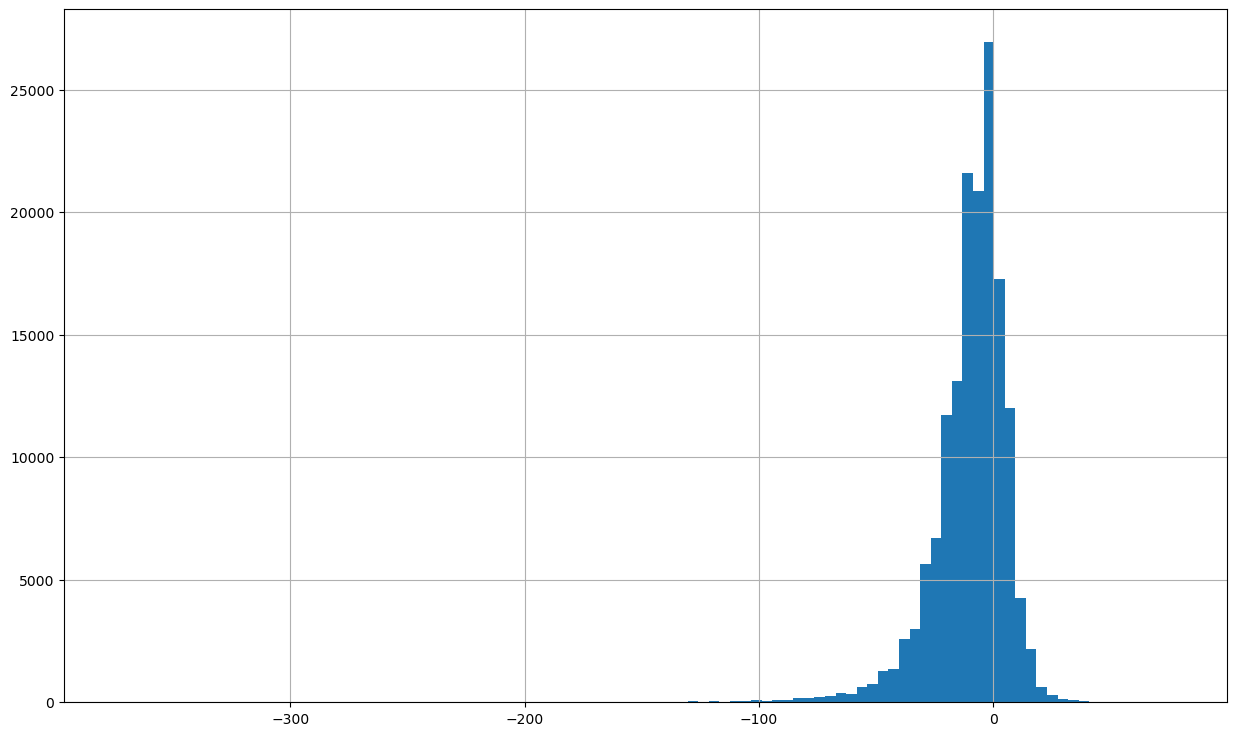

In [21]:
df["y_true"].hist(bins=100)

<AxesSubplot: >

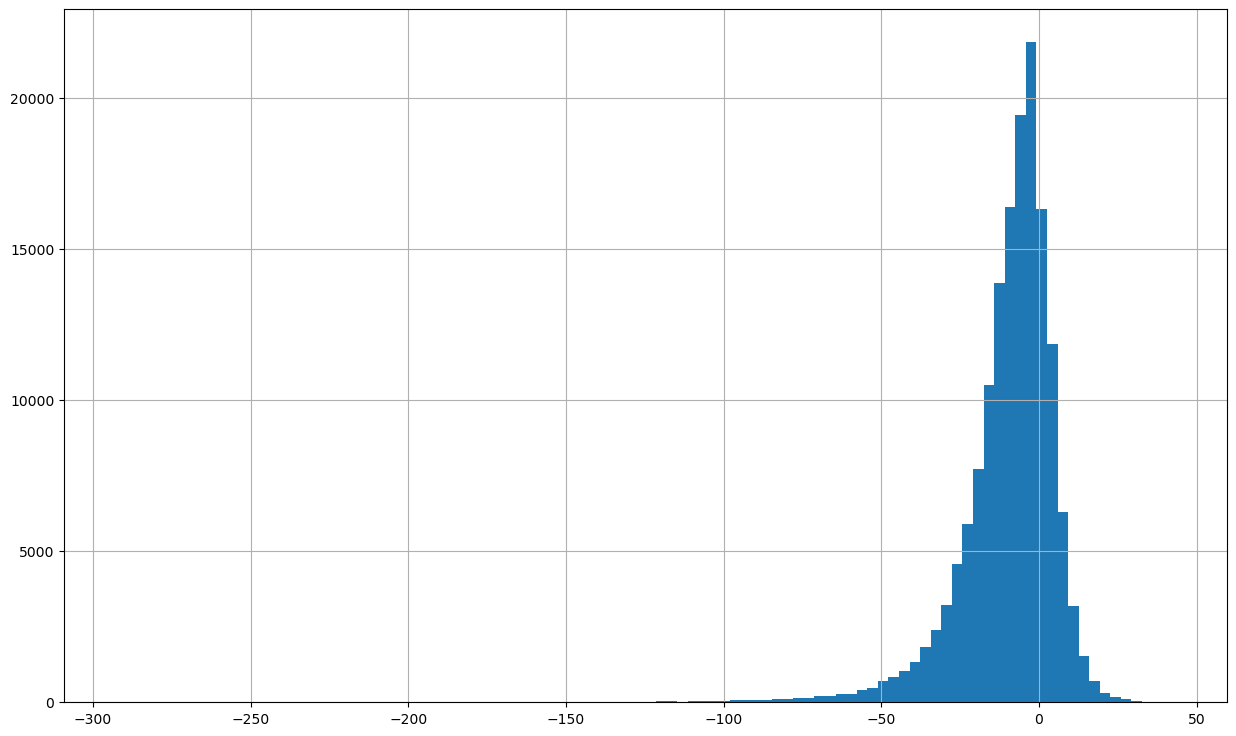

In [22]:
df["y_predict"].hist(bins=100)

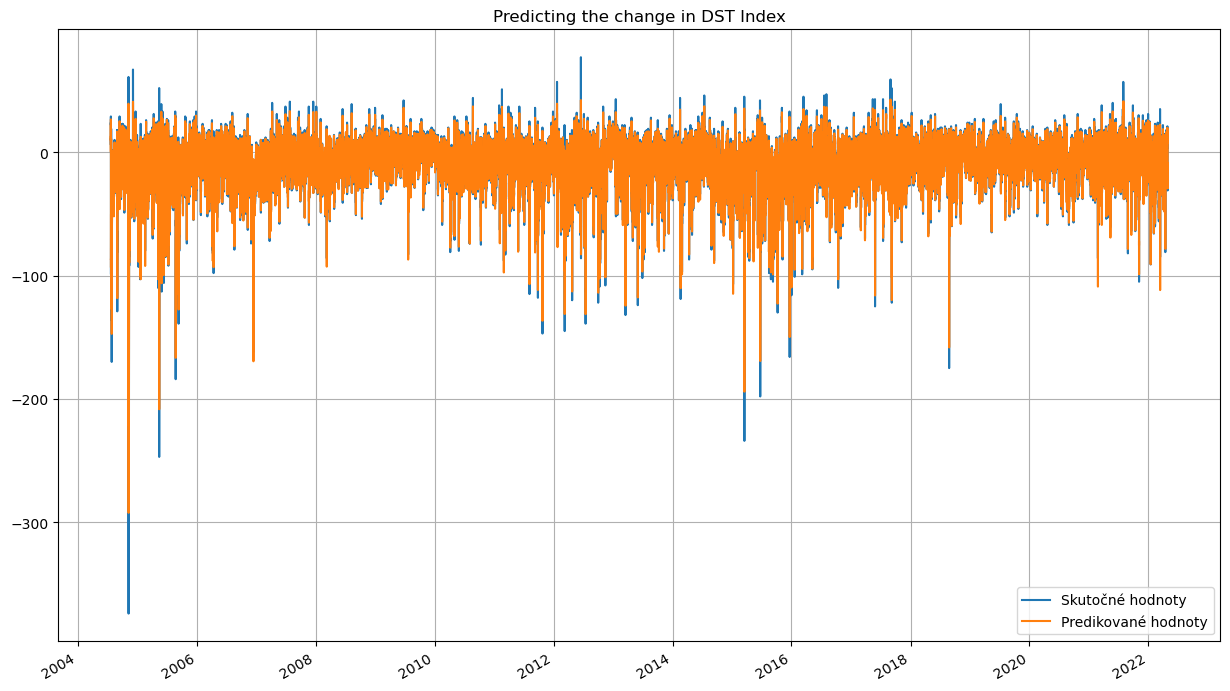

In [23]:
plt.figure()
plt.title('Predicting the change in DST Index')
plt.plot(df['time'],df['y_true'], label='Skutočné hodnoty')
plt.plot(df['time'],df['y_predict'], label='Predikované hodnoty')
plt.legend()
plt.gcf().autofmt_xdate()
plt.grid(True)

In [24]:
df.to_csv('predikcie_6h_dozadu.csv')

In [11]:
TN = cm[0,0] 
print(TN)
FP = cm[0,1]
print(FP)
FN = cm[1,0] 
print(FN)
TP = cm[1,1] 
print(TP)
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print("TPR={}".format(TPR))
# Specificity or true negative rate
TNR = TN/(TN+FP)
print("TNR={}".format(TNR))
# Precision or positive predictive value
PPV = TP/(TP+FP)
print("PPV={}".format(PPV))
# Negative predictive value
NPV = TN/(TN+FN)
print("NPV={}".format(NPV))
# Fall out or false positive rate
FPR = FP/(FP+TN)
print("FPR={}".format(FPR))
# False negative rate
FNR = FN/(TP+FN)
print("FNR={}".format(FNR))
# False discovery rate
FDR = FP/(TP+FP)
print("FDR={}".format(FDR))
# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
print("ACC={}".format(ACC))
MCC = matthews_corrcoef(y_test2, y_pred2)
print("MCC={}".format(MCC))

123350
1283
5182
25438
TPR=0.8307642064010451
TNR=0.9897057761588023
PPV=0.9519853298903485
NPV=0.9596831917343541
FPR=0.010294223841197757
FNR=0.16923579359895494
FDR=0.04801467010965158
ACC=0.9583582925933798
MCC=0.8648679991985954
